In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step1: Importing Packages

In [2]:
#imporitng the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime
import calendar
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Step2: Reading and Exploring Data

### 2.1 Reading the Data from CSV and Exploring metadata

In [3]:
dateparse = lambda x: datetime.datetime.strptime(x, '%d-%m-%Y')

df = pd.read_csv("/content/drive/MyDrive/Lecture Notes/Machine Learning 1/Assignment/Bike_Sharing-Linear_Regression/data/day.csv",
                 parse_dates=['dteday'],
                 date_parser=dateparse)
orignal_copy = df
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2018-01-01,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-01-03,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-01-04,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-01-05,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
#check the shape
df.shape

(730, 16)

In [5]:
#check dataframe for null and datatype 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    int64         
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

In [6]:
# Description of the data
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


### 2.2 Deriving New Data Columns using the columns which are available

In [7]:
# Creating a new column to check if its first day or last day of Month
df['start_of_month'] = df['dteday'].dt.is_month_start.astype(int)
df['end_of_month'] = df['dteday'].dt.is_month_end.astype(int)

# Deriving New column using date i.e "week_of_month"
def week_of_month(tgtdate):
    tgtdate = tgtdate.to_pydatetime()

    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break
    return (tgtdate - startdate).days //7 + 1

df['week_of_month'] = df['dteday'].apply(week_of_month)

# # Deriving Quarters for in coded for both year
# def q_num(m):
#   return int(str(m)[-1])

# df['quarter'] = df['quarter'].apply(q_num)

In [8]:
df['temp'].describe()

count    730.000000
mean      20.319259
std        7.506729
min        2.424346
25%       13.811885
50%       20.465826
75%       26.880615
max       35.328347
Name: temp, dtype: float64

In [9]:
# Bucket = [0, 13.0, 20.4, 26.88, 35.32, 99999999999]
# Bucket = [0, 8.75, 17.5, 26.25, 99999999999]
Bucket = [0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 99999999999]
df['temp_cat'] = df['temp'].value_counts(bins=Bucket)
df['temp_cat'].unique()

array([  4,  56, 160, 138, 130, 170,  72])

In [10]:
df['hum'].describe()

count    730.000000
mean      62.765175
std       14.237589
min        0.000000
25%       52.000000
50%       62.625000
75%       72.989575
max       97.250000
Name: hum, dtype: float64

In [11]:
Bucket = [0, 20.0, 40.0, 60.0, 80.0, 99999999.0]
df['hum_cat'] = df['hum'].value_counts(bins=Bucket)
df['hum_cat'].unique()

array([  2,  28, 292, 317,  91])

In [12]:
df['windspeed'].describe()

count    730.000000
mean      12.763620
std        5.195841
min        1.500244
25%        9.041650
50%       12.125325
75%       15.625589
max       34.000021
Name: windspeed, dtype: float64

In [13]:
Bucket = [0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 99999999.0]
df['windspeed_cat'] = df['windspeed'].value_counts(bins=Bucket)
df['windspeed_cat'].unique()

array([ 31, 211, 269, 148,  54,  16,   1])

# Step3: Cleaning Data

### 3.1 Cleaning the data type

In [14]:
# Removing Trailing Spaces in entire dataframe
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

### 3.2 Drop columns that are irrelavent

In [15]:
# Droping instant column since it has nothing to do with target
df.drop(['instant'], axis = 1, inplace = True)

# Dropping casual and registered Columns Since it's sum is directly the target. This could be a major issue for data leak
df.drop(['casual'], axis = 1, inplace = True)
df.drop(['registered'], axis = 1, inplace = True)

# Droping the dteday since date is not relavent here
df.drop(['dteday'], axis = 1, inplace = True)

# Droping the atemp since it is highly correlated to temp
df.drop(['atemp'], axis = 1, inplace = True)

### 3.2 Check for Missing values

- No missing Values were found as we have seen above. Verifying the claim for other columns:

In [16]:
df.isnull().sum()

season            0
yr                0
mnth              0
holiday           0
weekday           0
workingday        0
weathersit        0
temp              0
hum               0
windspeed         0
cnt               0
start_of_month    0
end_of_month      0
week_of_month     0
temp_cat          0
hum_cat           0
windspeed_cat     0
dtype: int64

### 3.3 Checking for Outliers in the dataset

In [17]:
#Unique values in all columns
df.nunique()

season              4
yr                  2
mnth               12
holiday             2
weekday             7
workingday          2
weathersit          3
temp              498
hum               594
windspeed         649
cnt               695
start_of_month      2
end_of_month        2
week_of_month       6
temp_cat            7
hum_cat             5
windspeed_cat       7
dtype: int64

As we can see
Categorical Values are season, yr, mnth, holiday, weekday, workingday, weathersit

Rest are continuous Variables 

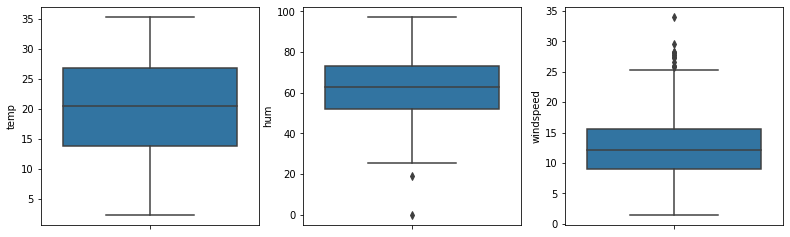

In [18]:
# Draw box plots for indepent variables with continuous values
# cols = ['temp', 'atemp', 'hum', 'windspeed']
cols = ['temp', 'hum', 'windspeed']
plt.figure(figsize=(18,4))

i = 1
for col in cols:
    plt.subplot(1,4,i)
    sns.boxplot(y=col, data=df)
    i+=1

As we can see that for all the contineuos variable, there are no outliers

# 4. EDA

#### 4.1 Converting Seasons , day, and months's numerical values to categorical values

In [19]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,start_of_month,end_of_month,week_of_month,temp_cat,hum_cat,windspeed_cat
0,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,985,1,0,1,4,2,31
1,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,801,0,0,1,4,2,31
2,1,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349,0,0,1,4,2,31
3,1,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562,0,0,1,4,2,31
4,1,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600,0,0,1,4,2,31


In [20]:
# df['week_of_month'].unique()

In [21]:
df.season.replace({1:"spring", 2:"summer", 3:"fall", 4:"winter"},inplace = True)

df.weathersit.replace({1:'clear',2:'Mist',3:'Snow',4:'Heavy_Rain'},inplace = True)

df.mnth = df.mnth.replace({1: 'jan',2: 'feb',3: 'mar',4: 'apr',5: 'may',6: 'jun',
                  7: 'jul',8: 'aug',9: 'sept',10: 'oct',11: 'nov',12: 'dec'})

df.weekday = df.weekday.replace({0: 'sun',1: 'mon',2: 'tue',3: 'wed',4: 'thu',5: 'fri',6: 'sat'})

df.temp_cat = df.temp_cat.replace({4: 'very_low', 56: 'low', 160: 'medium', 138: 'above_med', 130:'high', 170:'very_high', 72:'extremly_high'})

df.week_of_month = df.week_of_month.replace({1:'week_1', 2:'week_2', 3:'week_3', 4:'week_4', 5:'week_5', 0:'week_0'})

df.hum_cat = df.hum_cat.replace({2:'very_low', 28:'low', 292: 'med', 317:'high', 91:'very_high'})

df.windspeed_cat = df.windspeed_cat.replace({31:'very_low', 211:'low', 269: 'med', 148:'high', 54:'very_high', 16:'extremly_high', 1:'seriously_high'})
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,start_of_month,end_of_month,week_of_month,temp_cat,hum_cat,windspeed_cat
0,spring,0,jan,0,sat,0,Mist,14.110847,80.5833,10.749882,985,1,0,week_1,very_low,very_low,very_low
1,spring,0,jan,0,sun,0,Mist,14.902598,69.6087,16.652113,801,0,0,week_1,very_low,very_low,very_low
2,spring,0,jan,0,mon,1,clear,8.050924,43.7273,16.636703,1349,0,0,week_1,very_low,very_low,very_low
3,spring,0,jan,0,tue,1,clear,8.200000,59.0435,10.739832,1562,0,0,week_1,very_low,very_low,very_low
4,spring,0,jan,0,wed,1,clear,9.305237,43.6957,12.522300,1600,0,0,week_1,very_low,very_low,very_low


### 4.2 Data Analysis

We now step into Analysis of the data which has been cleaned. For Data Analysis, We can Classify it into Broad Terms:

*   Univariate Analysis
*   Bivariate Analysis
*   Multivariate Analysis

For sake of this Assignment, we will be focusing examples from Univariate Analysis and Bivariate Analysis.

These anaylsis can help give Driving Factors for taking key decisions in order to check for demand on different Parameters using our Linear Regression Models.

###4.2.1 Univariate Analysis

Univariate analysis is perhaps the simplest form of statistical analysis. Like other forms of statistics, it can be inferential or descriptive. The key fact is that only one variable is involved. Univariate analysis can yield misleading results in cases in which multivariate analysis is more appropriate.

Building on this, we go ahead and point out various Univariate Analysis results.

In [22]:
# Overall Average Count of the Bike Demand
print("Mean Count of Bike : {}".format(df['cnt'].mean()))

Mean Count of Bike : 4508.006849315068


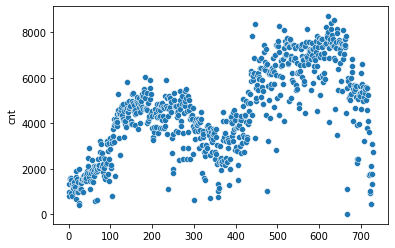

In [23]:
#Scatter Plot of Count
sns.scatterplot(df.index, df['cnt'])

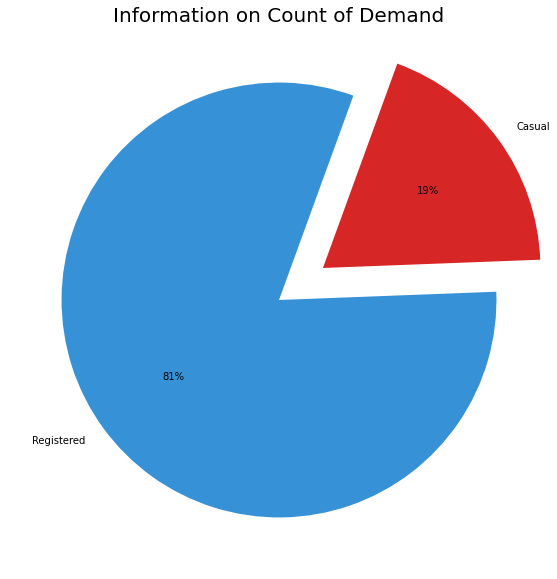

In [24]:
data = [orignal_copy['registered'].sum(), orignal_copy['casual'].sum()]
labels = ['Registered', 'Casual']
plt.figure(figsize = (10,10))
colors = ["#3791D7", "#D72626"]
plt.title('Information on Count of Demand', fontsize=20)
plt.pie(data,explode=[0,0.25], labels = labels, colors = colors, autopct='%.0f%%', startangle=70)
plt.show()

#### 4.2.2 Bivariate Analysis

Bivariate analysis is one of the simplest forms of quantitative analysis. It involves the analysis of two variables, for the purpose of determining the empirical relationship between them. Bivariate analysis can be helpful in testing simple hypotheses of association.

Building on Univariate Analysis, We can go ahead and start with Relationship between different variables in the dataset.

We performed Correlation for each Non-Categorical Data, i.e. Continuous data column to find any Correlations

<Figure size 1080x2160 with 0 Axes>

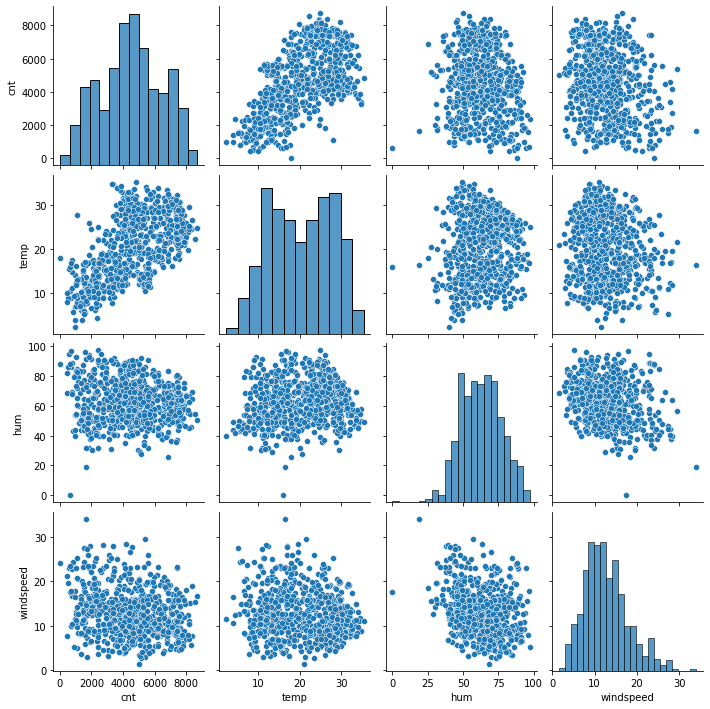

In [25]:
plt.figure(figsize = (15,30))
sns.pairplot(data=df,vars=['cnt', 'temp', 'hum','windspeed'])
plt.show()

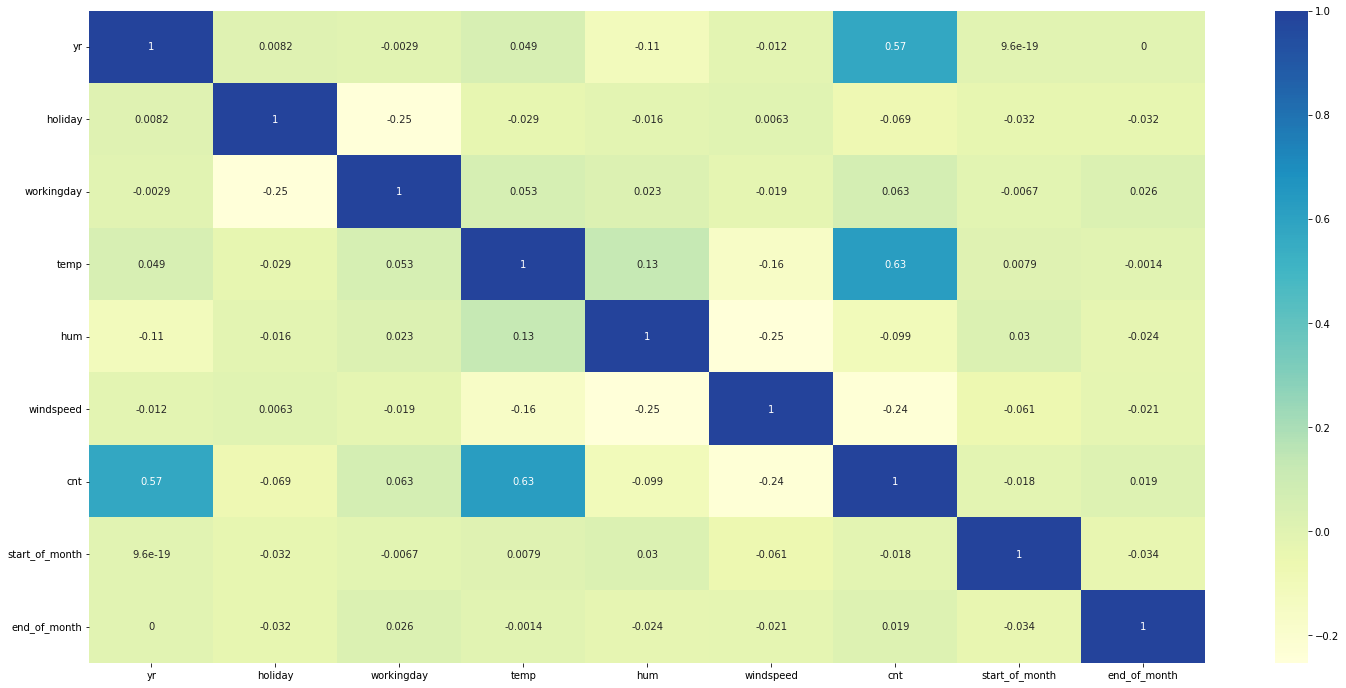

In [26]:
#Correlations for All variables
plt.figure(figsize = (25,12))
sns.heatmap(df.corr(), cmap="YlGnBu", annot = True , center=0.5)
plt.show()

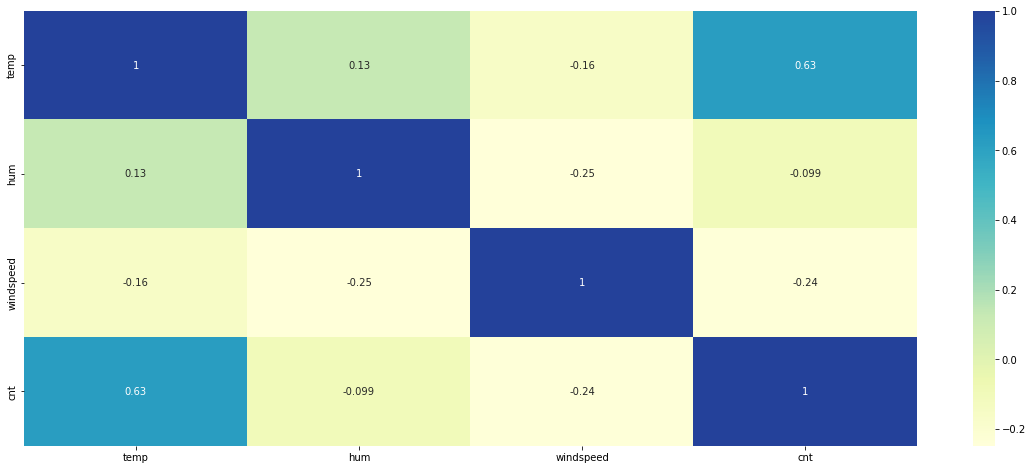

In [27]:
# Heat Map for Contineous Variables
plt.figure(figsize = (20,8))
sns.heatmap(df[['temp','hum','windspeed','cnt']].corr(), cmap='YlGnBu', annot = True, center=0.5)
plt.show()

#### From the correlation map, temp and atemp seems to be highly correlated. We can drop one of the columns later in model building
#### Target variable has a linear relationship with respect to indeptendent variables. We can check for Individual Linear relationship with fitting a line to the variables.

#### 4.3 Categorical Variabels distribution

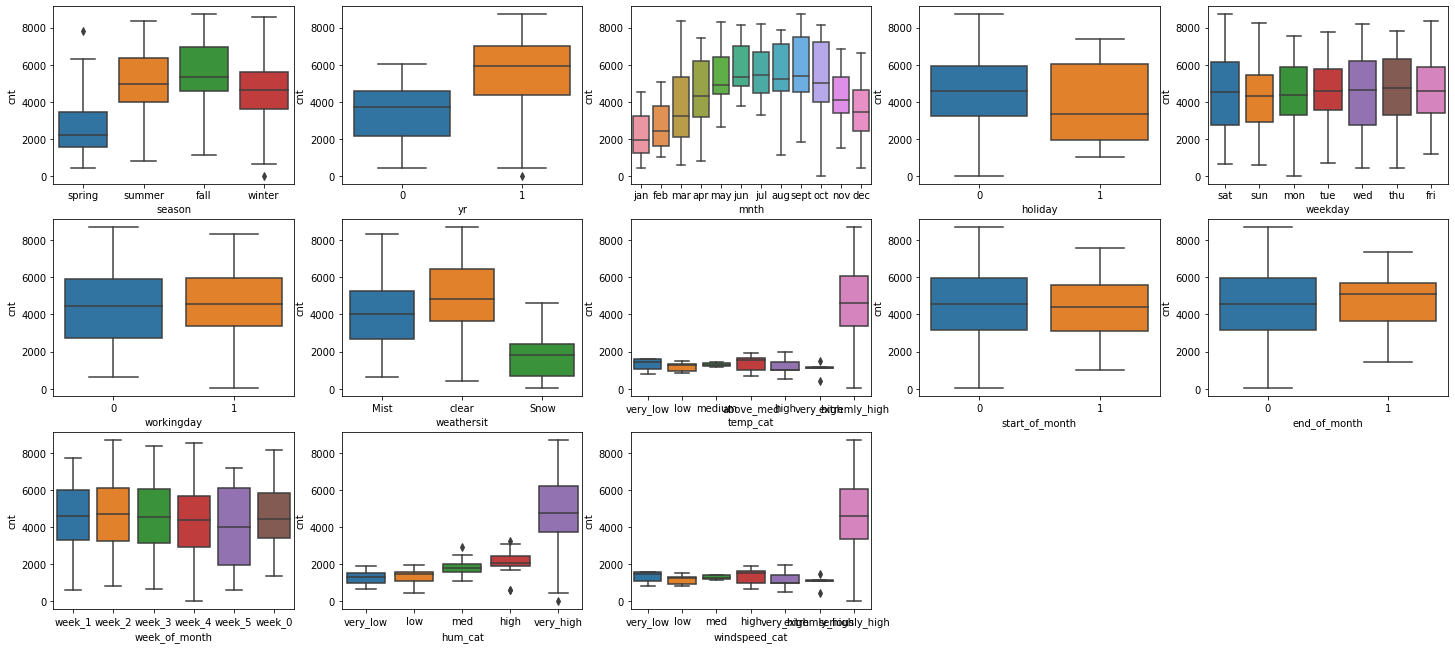

In [28]:
# Boxplot for categorical variables to see demands

lst = ['season','yr','mnth','holiday','weekday','workingday','weathersit', 'temp_cat',
       'start_of_month',	'end_of_month',	'week_of_month', 'hum_cat', 'windspeed_cat']

plt.figure(figsize=(25, 15))
for i in enumerate(lst):
    plt.subplot(4,5,i[0]+1)
    sns.boxplot(data=df, x=i[1], y='cnt')
plt.show()

#### Pointers:
1. Fall has the Higest Demand, whereas spring has the lowest demand
2. Demand in bike sharing business has increased in 2019 compared to 2018
3. Demand keeps on increasing till Septmeber, with september Month being month of Highest demand. And there is decreased demand in from Oct to Jan.
4. Hihger demand when it is not a Holiday.
5. Weekends have slighty higher demand, but the mean is more or less the same. We can derive that there is not much impact of day of week in the data. And similar is with working day
6. Bad weather has lowest demand, where as when the weather is good, there is a high demand.
7. From the demand scale on quaters, there seems to be a steady upward trend in demand for every quater
8. Start of the Month has less deviation in demand compared to rest of the days.
9. End of the Month also has less deviation in demand compared to rest of the days.
10. Week of the Month does not have much to say

####4.4 Fitting the Line in the Graph

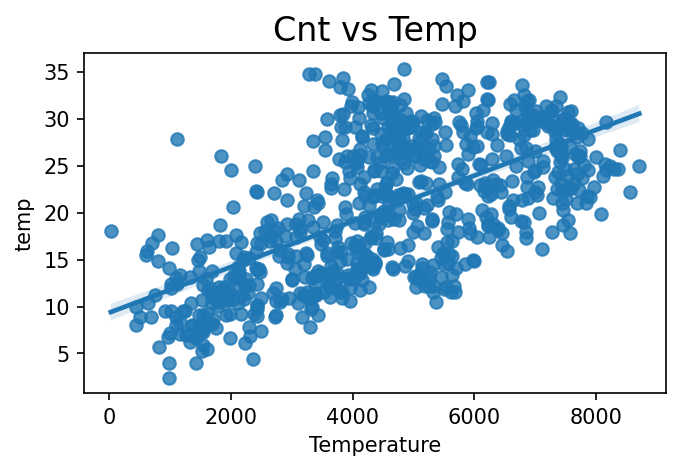

In [29]:
plt.figure(figsize=(5,3),dpi=150)
plt.title("Cnt vs Temp",fontsize=16)
sns.regplot(data=df,x="cnt",y="temp")
plt.xlabel("Temperature")
plt.show()

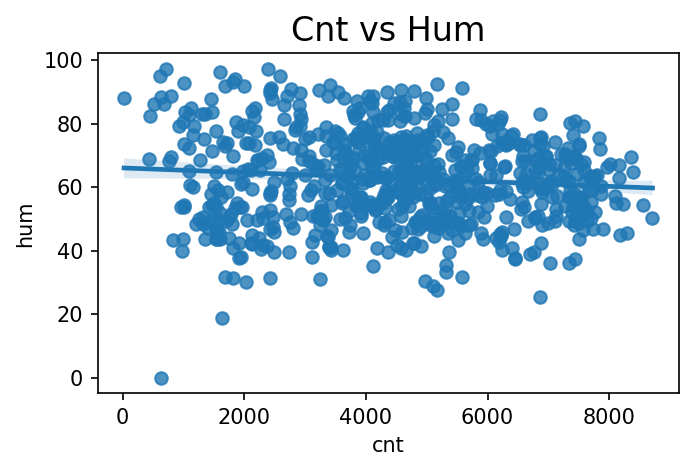

In [30]:
plt.figure(figsize=(5,3),dpi=150)
plt.title("Cnt vs Hum",fontsize=16)
sns.regplot(data=df,x="cnt",y="hum")
plt.show()

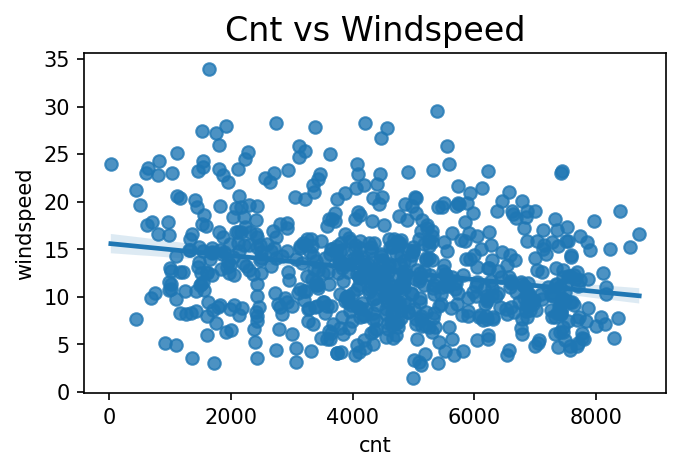

In [31]:
plt.figure(figsize=(5,3),dpi=150)
plt.title("Cnt vs Windspeed",fontsize=16)
sns.regplot(data=df,y="windspeed",x="cnt")
plt.show()

### Pointers
1. Temparture is highly correlated to count
2. Windspeed also has a decent effect of the Count
3. Percent change of the variables seems to have horizontal line plot

# 5. Data Preparation for Model Building

#### 5.1 Creating dummy variables for all the categorical Columns

In [32]:
df = pd.get_dummies(data=df,columns=["season","mnth","weekday", "week_of_month",
                                     'windspeed_cat', 'hum_cat', "weathersit", "temp_cat"],drop_first=True)

In [33]:
# Filling NaN row with average of the column and handling infinite values to scale them to 0
df = df.fillna(df.mean())
df.replace(np.inf, 0, inplace=True)

In [34]:
df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt',
       'start_of_month', 'end_of_month', 'season_spring', 'season_summer',
       'season_winter', 'mnth_aug', 'mnth_dec', 'mnth_feb', 'mnth_jan',
       'mnth_jul', 'mnth_jun', 'mnth_mar', 'mnth_may', 'mnth_nov', 'mnth_oct',
       'mnth_sept', 'weekday_mon', 'weekday_sat', 'weekday_sun', 'weekday_thu',
       'weekday_tue', 'weekday_wed', 'week_of_month_week_1',
       'week_of_month_week_2', 'week_of_month_week_3', 'week_of_month_week_4',
       'week_of_month_week_5', 'windspeed_cat_high', 'windspeed_cat_low',
       'windspeed_cat_med', 'windspeed_cat_seriously_high',
       'windspeed_cat_very_high', 'windspeed_cat_very_low', 'hum_cat_low',
       'hum_cat_med', 'hum_cat_very_high', 'hum_cat_very_low',
       'weathersit_Snow', 'weathersit_clear', 'temp_cat_extremly_high',
       'temp_cat_high', 'temp_cat_low', 'temp_cat_medium',
       'temp_cat_very_high', 'temp_cat_very_low'],
      dtype='object')

In [35]:
df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,start_of_month,end_of_month,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,week_of_month_week_1,week_of_month_week_2,week_of_month_week_3,week_of_month_week_4,week_of_month_week_5,windspeed_cat_high,windspeed_cat_low,windspeed_cat_med,windspeed_cat_seriously_high,windspeed_cat_very_high,windspeed_cat_very_low,hum_cat_low,hum_cat_med,hum_cat_very_high,hum_cat_very_low,weathersit_Snow,weathersit_clear,temp_cat_extremly_high,temp_cat_high,temp_cat_low,temp_cat_medium,temp_cat_very_high,temp_cat_very_low
0,0,0,0,14.110847,80.5833,10.749882,985,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
1,0,0,0,14.902598,69.6087,16.652113,801,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1


# 6. Model Building

## 5.1 Spliting Data into training and test data

In [36]:
#y to contain only target variable
y = df.pop('cnt')

#X is all remainign variable also our independent variables
X = df

#Train Test split with 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [37]:
# Checking shape and size for train and test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(511, 51)
(219, 51)
(511,)
(219,)


### 5.2 Scaling continuous variables

In [38]:
#Using MinMax scaler to scale all the variable fron 0 to 1
scaler = MinMaxScaler()
# num_vars = ['temp','atemp','hum','windspeed', 'hum_pct_change', 'temp_pct_change','windspeed_pct_change']
# num_vars = ['temp','atemp','hum','windspeed']
num_vars = ['temp','hum','windspeed']
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])

In [39]:
X_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,start_of_month,end_of_month,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,week_of_month_week_1,week_of_month_week_2,week_of_month_week_3,week_of_month_week_4,week_of_month_week_5,windspeed_cat_high,windspeed_cat_low,windspeed_cat_med,windspeed_cat_seriously_high,windspeed_cat_very_high,windspeed_cat_very_low,hum_cat_low,hum_cat_med,hum_cat_very_high,hum_cat_very_low,weathersit_Snow,weathersit_clear,temp_cat_extremly_high,temp_cat_high,temp_cat_low,temp_cat_medium,temp_cat_very_high,temp_cat_very_low
count,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,0.508806,0.025440,0.677104,0.537386,0.650333,0.320844,0.039139,0.029354,0.242661,0.246575,0.248532,0.095890,0.084149,0.066536,0.088063,0.076321,0.076321,0.097847,0.084149,0.086106,0.086106,0.080235,0.150685,0.154599,0.142857,0.133072,0.133072,0.158513,0.223092,0.232877,0.236791,0.183953,0.027397,0.007828,0.007828,0.007828,0.954990,0.003914,0.009785,0.027397,0.023483,0.886497,0.033268,0.029354,0.626223,0.954990,0.003914,0.007828,0.007828,0.007828,0.009785
std,0.500412,0.157613,0.468042,0.225640,0.145741,0.169639,0.194115,0.168963,0.429112,0.431440,0.432585,0.294729,0.277883,0.249461,0.283664,0.265771,0.265771,0.297399,0.277883,0.280795,0.280795,0.271923,0.358092,0.361876,0.350270,0.339986,0.339986,0.365579,0.416727,0.423079,0.425529,0.387826,0.163398,0.088214,0.088214,0.088214,0.207529,0.062500,0.098529,0.163398,0.151581,0.317517,0.179512,0.168963,0.484280,0.207529,0.062500,0.088214,0.088214,0.088214,0.098529
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.341151,0.538858,0.199179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542077,0.653499,0.298098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.754401,0.414438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.

####As we can see all the variables have been scaled from 0 to 1 now

In [40]:
X_train.head()

,yr,holiday,workingday,temp,hum,windspeed,start_of_month,end_of_month,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,week_of_month_week_1,week_of_month_week_2,week_of_month_week_3,week_of_month_week_4,week_of_month_week_5,windspeed_cat_high,windspeed_cat_low,windspeed_cat_med,windspeed_cat_seriously_high,windspeed_cat_very_high,windspeed_cat_very_low,hum_cat_low,hum_cat_med,hum_cat_very_high,hum_cat_very_low,weathersit_Snow,weathersit_clear,temp_cat_extremly_high,temp_cat_high,temp_cat_low,temp_cat_medium,temp_cat_very_high,temp_cat_very_low
653,1,0,1,0.509887,0.575354,0.300794,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0
576,1,0,1,0.815169,0.725633,0.264686,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
728,1,0,0,0.245101,0.498067,0.663106,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0


#### Approach used is combination of Auto Elimination using RFE and Manual Elimination

In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511 entries, 653 to 520
Data columns (total 51 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   yr                            511 non-null    int64  
 1   holiday                       511 non-null    int64  
 2   workingday                    511 non-null    int64  
 3   temp                          511 non-null    float64
 4   hum                           511 non-null    float64
 5   windspeed                     511 non-null    float64
 6   start_of_month                511 non-null    int64  
 7   end_of_month                  511 non-null    int64  
 8   season_spring                 511 non-null    uint8  
 9   season_summer                 511 non-null    uint8  
 10  season_winter                 511 non-null    uint8  
 11  mnth_aug                      511 non-null    uint8  
 12  mnth_dec                      511 non-null    uint8  
 13  mnt

### 5.3 RFE for atomating selection of variables

In [42]:
# Lienar Regression model using RFE
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [43]:
# using RFE to rank the columns upto 18
rfe = RFE(lr, n_features_to_select=18, step=1, verbose=0, importance_getter='auto')
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=18)

In [44]:
# Columns ranked by thier weights
test_list = list(zip(X_train.columns,rfe.support_,rfe.ranking_))
test_list.sort(key = lambda test_list: test_list[2])
test_list

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('end_of_month', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('mnth_jan', True, 1),
 ('mnth_jul', True, 1),
 ('mnth_sept', True, 1),
 ('weekday_sat', True, 1),
 ('windspeed_cat_high', True, 1),
 ('windspeed_cat_low', True, 1),
 ('weathersit_Snow', True, 1),
 ('weathersit_clear', True, 1),
 ('mnth_nov', False, 2),
 ('mnth_dec', False, 3),
 ('temp_cat_extremly_high', False, 4),
 ('windspeed_cat_very_low', False, 5),
 ('temp_cat_very_high', False, 6),
 ('windspeed_cat_seriously_high', False, 7),
 ('temp_cat_very_low', False, 8),
 ('windspeed_cat_med', False, 9),
 ('hum_cat_very_low', False, 10),
 ('temp_cat_high', False, 11),
 ('temp_cat_low', False, 12),
 ('windspeed_cat_very_high', False, 13),
 ('mnth_feb', False, 14),
 ('hum_cat_low', False, 15),
 ('start_of_month', False, 16),
 ('week_of_month_week_4',

## 5.4 Manual Selection

Since we will be using similar approaches to calculate VIF and build multiple models. We create 2 different functions for the same

In [45]:
#Function for Model building using statsmodel api
def build_model(cols):
    X_train_sm = sm.add_constant(X_train[cols])
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return lm

#Calculate VIF
def get_vif(cols):
    df1 = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))

In [46]:
#Print Columns selected by RFE. We will start with these columns for manual elimination
X_train.columns[rfe.support_]

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'end_of_month', 'season_spring', 'season_summer', 'season_winter',
       'mnth_jan', 'mnth_jul', 'mnth_sept', 'weekday_sat',
       'windspeed_cat_high', 'windspeed_cat_low', 'weathersit_Snow',
       'weathersit_clear'],
      dtype='object')

In [47]:
# Features not selected by RFE
X_train.columns[~rfe.support_]

Index(['start_of_month', 'mnth_aug', 'mnth_dec', 'mnth_feb', 'mnth_jun',
       'mnth_mar', 'mnth_may', 'mnth_nov', 'mnth_oct', 'weekday_mon',
       'weekday_sun', 'weekday_thu', 'weekday_tue', 'weekday_wed',
       'week_of_month_week_1', 'week_of_month_week_2', 'week_of_month_week_3',
       'week_of_month_week_4', 'week_of_month_week_5', 'windspeed_cat_med',
       'windspeed_cat_seriously_high', 'windspeed_cat_very_high',
       'windspeed_cat_very_low', 'hum_cat_low', 'hum_cat_med',
       'hum_cat_very_high', 'hum_cat_very_low', 'temp_cat_extremly_high',
       'temp_cat_high', 'temp_cat_low', 'temp_cat_medium',
       'temp_cat_very_high', 'temp_cat_very_low'],
      dtype='object')

In [48]:
# Taking 18 columns supported by RFE for regression
X_train_rfe = X_train[list(X_train.columns[rfe.support_])]
X_train_rfe.shape

(511, 18)

# 6. Model Building and Score Checks 
All the columns supported by the RFE

In [49]:
cols = list(X_train.columns[rfe.support_])
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     156.4
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          2.74e-190
Time:                        12:37:25   Log-Likelihood:                -4109.7
No. Observations:                 511   AIC:                             8257.
Df Residuals:                     492   BIC:                             8338.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1615.2936    345

In [50]:
cols.remove('windspeed_cat_low')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     164.8
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          9.42e-191
Time:                        12:37:25   Log-Likelihood:                -4111.3
No. Observations:                 511   AIC:                             8259.
Df Residuals:                     493   BIC:                             8335.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1674.1035    344

In [51]:
cols.remove('windspeed_cat_high')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     174.1
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          3.57e-191
Time:                        12:37:25   Log-Likelihood:                -4113.0
No. Observations:                 511   AIC:                             8260.
Df Residuals:                     494   BIC:                             8332.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1673.5028    344.842  

In [52]:
cols.remove('end_of_month')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.5
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          1.50e-191
Time:                        12:37:25   Log-Likelihood:                -4114.8
No. Observations:                 511   AIC:                             8262.
Df Residuals:                     495   BIC:                             8329.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1714.6235    345.038  

In [53]:
cols.remove('mnth_jan')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.2
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          7.31e-192
Time:                        12:37:25   Log-Likelihood:                -4116.8
No. Observations:                 511   AIC:                             8264.
Df Residuals:                     496   BIC:                             8327.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1613.0171    342.188  

In [54]:
cols.remove('holiday')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     209.4
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          5.37e-192
Time:                        12:37:26   Log-Likelihood:                -4119.3
No. Observations:                 511   AIC:                             8267.
Df Residuals:                     497   BIC:                             8326.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1532.5197    341.518  

In [55]:
cols.remove('season_spring')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     223.3
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          1.36e-191
Time:                        12:37:26   Log-Likelihood:                -4123.1
No. Observations:                 511   AIC:                             8272.
Df Residuals:                     498   BIC:                             8327.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1040.7100    291.575  

In [56]:
cols.remove('mnth_jul')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     240.6
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          1.73e-191
Time:                        12:37:26   Log-Likelihood:                -4126.1
No. Observations:                 511   AIC:                             8276.
Df Residuals:                     499   BIC:                             8327.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1032.6767    293.032  

In [57]:
cols.remove('hum')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     253.7
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          1.13e-188
Time:                        12:37:26   Log-Likelihood:                -4135.7
No. Observations:                 511   AIC:                             8293.
Df Residuals:                     500   BIC:                             8340.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -30.7004    165.021  

In [58]:
cols.remove('weathersit_clear')
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     233.6
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          5.58e-173
Time:                        12:37:26   Log-Likelihood:                -4175.6
No. Observations:                 511   AIC:                             8371.
Df Residuals:                     501   BIC:                             8413.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             381.1259    171.541     

In [59]:
#Build a model with all columns to select features automatically
def build_model_sk(X,y):
    lr1 = LinearRegression()
    lr1.fit(X,y)
    return lr1
  
lr = build_model_sk(X_train[cols],y_train)
print(lr.intercept_,lr.coef_)

381.12585021086124 [ 2037.00169048   428.48717055  4960.56476287 -1277.61871767
   707.85510824  1117.15086051   743.60134517   527.75589372
 -2236.57275369]


## Step 7. Model Evaluation 
### 7.1 Residucal Analysis

In [60]:
y_train_pred = lr.predict(X_train[cols])

####7.1.1 Distribution of Error Terms

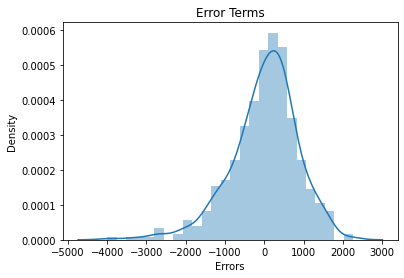

In [61]:
#histogram of the error terms
def plot_res_dist(act, pred):
    sns.distplot(act-pred)
    plt.title('Error Terms')
    plt.xlabel('Errors')

plot_res_dist(y_train, y_train_pred)

Error terms are normally distributed with mean at 0.

####7.1.2 Homoscedasticity check

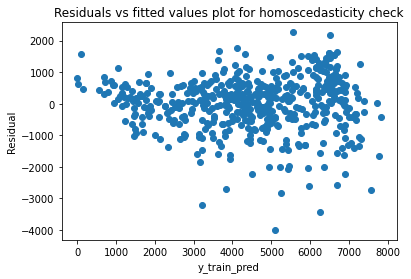

In [62]:
residual = (y_train - y_train_pred)
plt.scatter(y_train_pred,residual)
plt.ylabel("Residual")
plt.xlabel("y_train_pred")
plt.title('Residuals vs fitted values plot for homoscedasticity check')
plt.show()

####7.2 Testing on Test data

In [63]:
#scaling and transforming test data
num_vars = ['temp','hum','windspeed']
X_test[num_vars] = scaler.transform(X_test[num_vars])

In [73]:
lm_final = build_model(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     233.6
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          5.58e-173
Time:                        12:52:21   Log-Likelihood:                -4175.6
No. Observations:                 511   AIC:                             8371.
Df Residuals:                     501   BIC:                             8413.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             381.1259    171.541     

In [75]:
#Predict the count on test data
y_test_pred = lr.predict(X_test[cols])

In [76]:
# R squared value between test and predicted test.  
r2_score(y_test,y_test_pred)

0.7729354285045361

In [77]:
# Adj. R-Squared for test dataset
var_final = list(lm_final.params.index)
N= len(X_test)
p =len(var_final)
r2_test_adj = round((1-((1-r2_test)*(N-1)/(N-p-1))),3)
print('Adj. R-Squared for Test dataset: ', round(r2_test_adj,3))

Adj. R-Squared for Test dataset:  0.762


####7.3 Randomly Distributed Error Terms

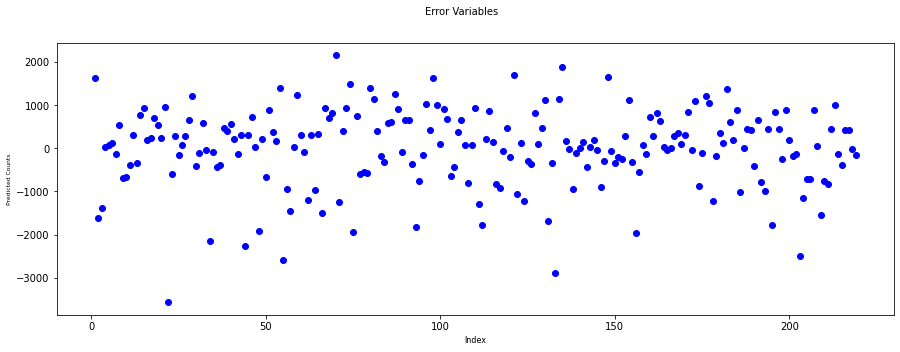

In [78]:
# Error terms
def plot_err_terms(act,pred):
    c = [i for i in range(1,220,1)]
    fig = plt.figure(figsize=(15,5))
    plt.plot(c,act-pred, color="blue" , marker='o', linewidth=2.5, linestyle="")
    fig.suptitle('Error Variables', fontsize=10)
    plt.xlabel('Index', fontsize=8)
    plt.ylabel('Predicted Counts', fontsize=6)


plot_err_terms(y_test,y_test_pred)

In [79]:
# Print R Squared and adj. R Squared
r2_test = r2_score(y_test,y_test_pred)
print('R- Sqaured train: ', round(lm_final.rsquared,2), '  Adj. R-Squared train:', round(lm_final.rsquared_adj,3) )
print('R- Sqaured test : ', round(r2_test,2), '  Adj. R-Squared test :', round(r2_test_adj,3))

# Print the coefficents of final varible
print('\033[1m{:10s}\033[0m'.format('\nCoefficent for the variables are:'))
print(round(lm_final.params,3))

R- Sqaured train:  0.81   Adj. R-Squared train: 0.804
R- Sqaured test :  0.77   Adj. R-Squared test : 0.762

Coefficent for the variables are:
const               381.126
yr                 2037.002
workingday          428.487
temp               4960.565
windspeed         -1277.619
season_summer       707.855
season_winter      1117.151
mnth_sept           743.601
weekday_sat         527.756
weathersit_Snow   -2236.573
dtype: float64


##Model and Model Predictions


1.   Model has a R-Squared Score of 0.80 and Adjusted R-Squared score of 0.804.
2.   The Predicted R-Squared Score was close to 0.772 which shows good relation to model and that the model is not biased.
3. P-Values of all the variables are 0.
4. There is Low Colinearity in the model, since the VIF Check reults in all the variables to be below 5.0 which is good threshold practice.

####*Final Model fit can be given as:*

*cnt = 381.126 + (2037.002*yr) + (428.487*workingday) + (4960.565*temp) - (1277.619*windspeed) + (707.855*season_summer) + (1117.151*season_winter) + (743.601*mnth_sept) + (527.756*weekday_sat) - (-2236.573*weathersit_Snow)*


##Conclusions:


1.   Temprature and Count are directly correlated. i.e. Higher the temprature more the demand
2.   The variable working day has good correlation and a strong variable to predict the Demand
3.  The Variable windspeed is Negatively correlated, i.e. higher the windspeed, less the demand. Business can use this time for maintenance of bikes
4.  If Weather Sitation is category 2, then it is negatively Correlated, and hence it can be excpected that there will be lower demand.
5. Month of September has highest demand as per the trendline.



